# Modified Sightline/Extraction Boxes

This notebook will help me identify the new sightline extraction boxes. It will be done using a whitelight image inside a jupyter notebook (not QFitsView) so the sightlines will be zero-based

Based on a 2023.11.13 meeting with Rongmon, I will define new extraction boxes (fewer boxes covering more of the arc). We will assume that these boxes are large enough that I won't have to worry about SNR at all -- so ignoring those complexities for now.

Once I have identified the extraction boxes in this code, I will transfer those extraction boxes over to j1429_extraction_tool_v5.py
This code will map those extraction boxes to the 7 independent exposures/observations (ensuring that each pixel covered by an extraction box is accounted for, but only once - a pixel at most can be associated with only 1 extraction box)

## Method
* Processing
  * get astrometry correct flux cube as our reference
    * create a whitelight image and wcs_ref
  * get extraction boxes for each sightline
  * load observations/expsures, create array of whitelight images and wcs_cur for each exposure
* Visualization:
  * create 1+7 layout with wcs_ref and wcs_cur projections
  * plot wl_ref and extraction boxes
    * different color for each extraction box
  * plot wl_obs and extraction boxes
    * different color for each extraction box
    * pixel identification: starting with extraction boxes from left to right
      * if extraction box contains or overlaps with a pixel, 
        * if that pixel isn't associated with any previously-seen extraction box
          * associate that pixel with this extraction box 
        * unless that pixel is already associated with another extraction box
      * color each pixel associated with extraction box with alpha = 0.5


In [1]:
# jupyterlab/mac/matplotlib inline craziness
# NOTE: You need the following lines for jupyter lab (commandline) to work on Mac !!!!
# NOTE: and you MUST run this cell twice (I don't know why) to get the image to appear inline
%matplotlib widget 
%matplotlib inline 
import matplotlib
matplotlib.use('TkAgg') 

In [2]:
# %matplotlib qt - this conflicts with kcwitools.io (WTF?)
# import matplotlib
# matplotlib.use('TkAgg') 
# %matplotlib inline 

In [3]:
# imports

import sys, os, glob, time
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

from kcwitools.io import open_kcwi_cube
from kcwitools.utils import build_wave
from kcwitools import image as im

from astropy.wcs import WCS, FITSFixedWarning
import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=FITSFixedWarning)

bu_path = '/Users/robertseaton/School/github_repos/CGM-learning/code'
if bu_path not in sys.path:
    sys.path.append(bu_path)
from bobutils import utils as bu, fileio as bio, layout_utils as lu, sightlines as bus, plotutils as bp, observations as bo

global_narrowband_min = 4676. 
global_narrowband_max = 4696. 
global_lw = 0.5
global_cmap = 'gnuplot'


In [4]:
# define sightline coordinates + aperture sizes
sightlines = bus.load_231113_sightlines()
# xs, ys, ws, hs = bus.get_xywhs(sightlines) # do we need these for plotting?

wl_image, wcs_ref = bio.load_narrowband_reference_image(global_narrowband_min, global_narrowband_max)
sightlines = bus.add_radec_to_sightlines(wcs_ref, sightlines)

for sl in sightlines:
    print(f"{sl}")


Sightline 1: x=27, y=36, w=3, h=9, radecs=(array([217.47922646, 217.47897812]), array([12.04354425, 12.04427289])) 
Sightline 2: x=30, y=37, w=3, h=11, radecs=(array([217.47897812, 217.47872977]), array([12.04354425, 12.04443481])) 
Sightline 3: x=33, y=38, w=3, h=11, radecs=(array([217.47872977, 217.47848142]), array([12.04362521, 12.04451577])) 
Sightline 4: x=36, y=39, w=3, h=11, radecs=(array([217.47848142, 217.47823308]), array([12.04370617, 12.04459673])) 
Sightline 5: x=40, y=39, w=5, h=7, radecs=(array([217.47823308, 217.47781916]), array([12.04386809, 12.04443481])) 
Sightline 6: x=49, y=31, w=11, h=7, radecs=(array([217.47773639, 217.47682578]), array([12.04322041, 12.04378712])) 
Sightline 7: x=34, y=23, w=11, h=7, radecs=(array([217.47897812, 217.47806751]), array([12.04257273, 12.04313945])) 


ax_type: WCSAxes


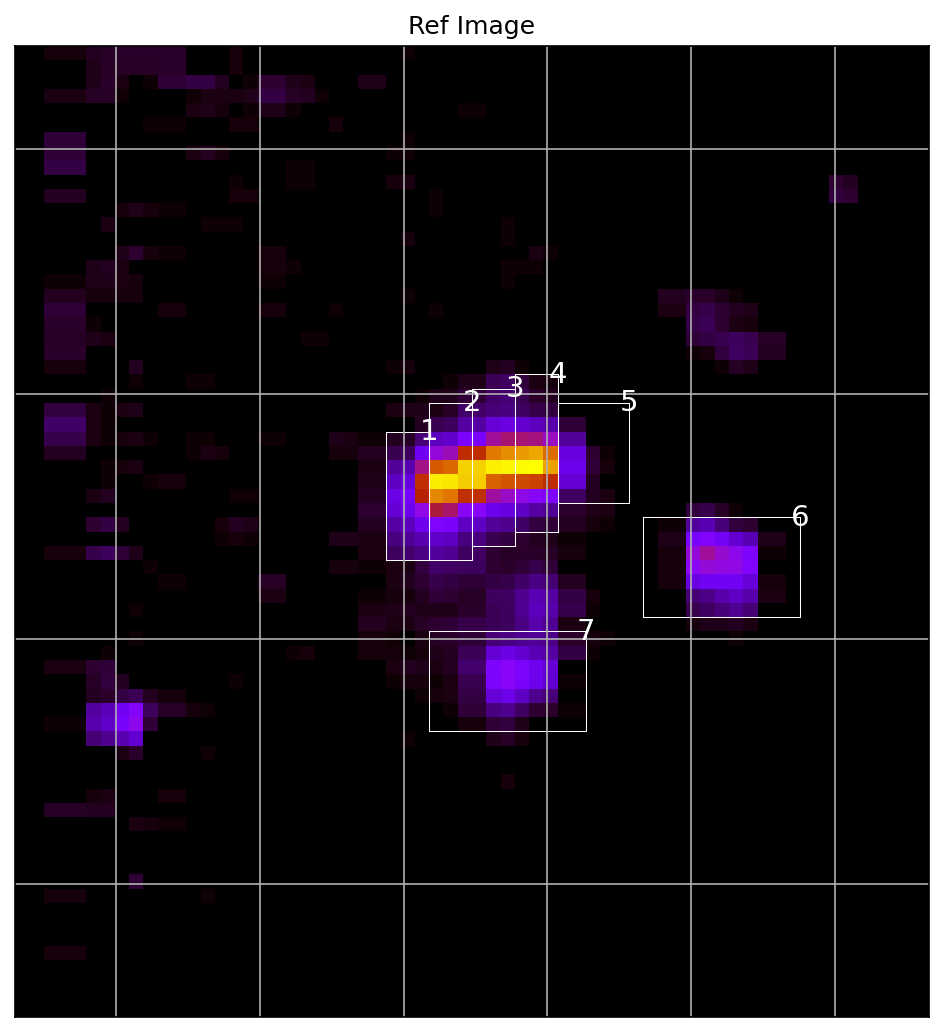

In [5]:
# draw whitelight image
plt.close()
fig = plt.figure(figsize=(8,8), dpi=200)
# ax = fig.add_subplot(111, projection=wcs_ref)
ax = fig.add_axes((0,0,1,1), projection=wcs_ref, polar=False)


bp.show_wl_image(ax, wl_image, title="Ref Image")
bp.plot_sightlines_wcs(ax, wcs_ref, sightlines, lw=0.5, show_label=True)

# display(fig.canvas) # cool, interactive canvas in notebook (don't work for me yet)
display(fig) # plots the figure as a static png


In [6]:
obs = bio.get_corrected_kcwi_data(global_narrowband_min, global_narrowband_max)


In [7]:
def plot_observation(oindex):
    ob = obs[oindex]
    plt.close()
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_axes((0,0,1,1), projection=ob._wcs_f, polar=False)
    ax.margins(-0.25) # zoom a little

    bp.show_wl_image(ax, ob.wl_k, title=f"Observation {oindex}")
    bp.plot_sightlines_wcs(ax, ob._wcs_f, sightlines, lw=0.5, show_label=True)
    display(fig) # plots the figure as a static png

ax_type: WCSAxes


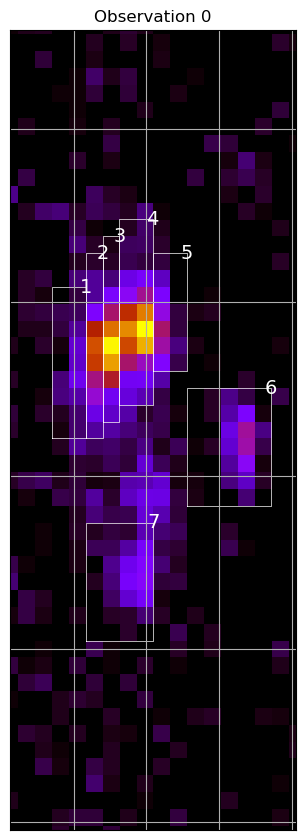

ax_type: WCSAxes


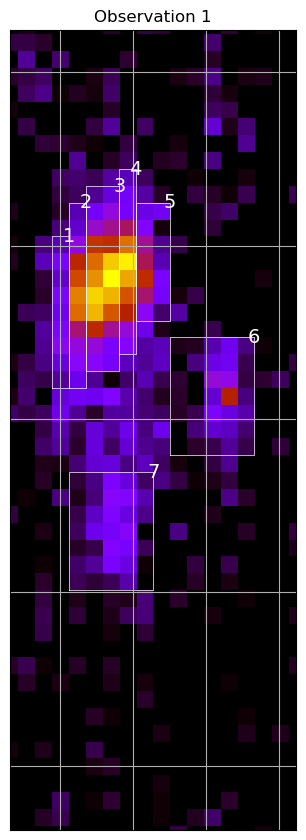

ax_type: WCSAxes


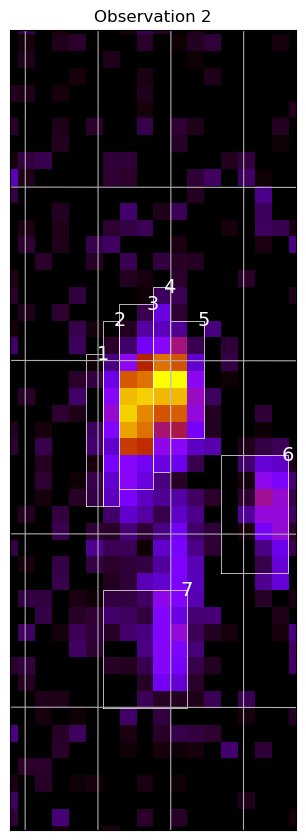

ax_type: WCSAxes


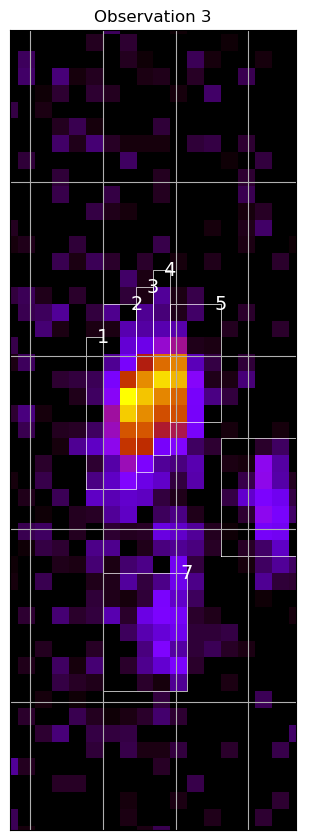

ax_type: WCSAxes


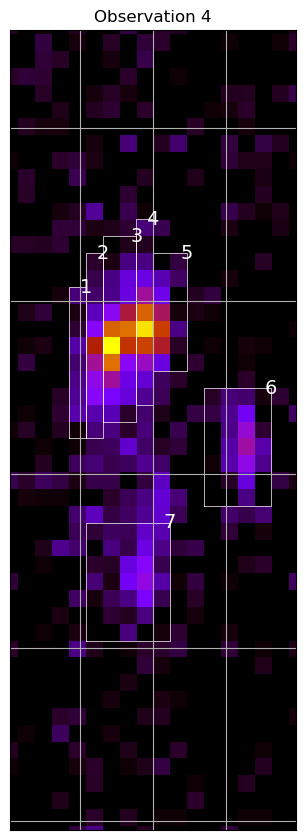

ax_type: WCSAxes


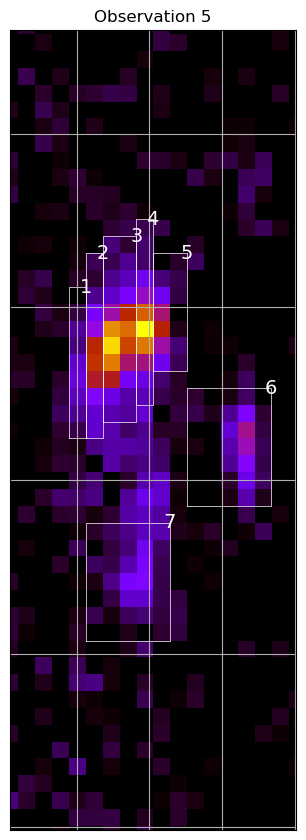

ax_type: WCSAxes


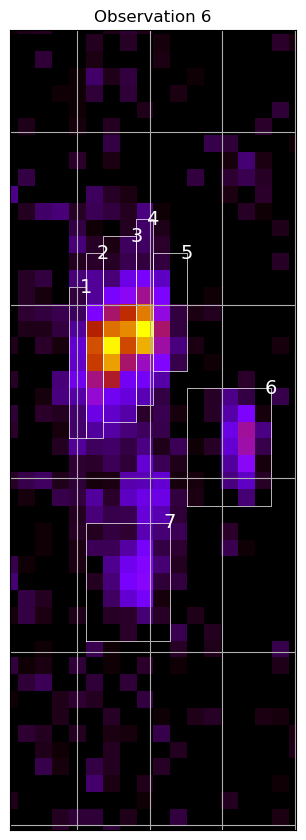

In [8]:

for i in range(len(obs)): plot_observation(i)



In [9]:
def plot_spectra(sl, xspec, label=f"Sightline: {sl.label}", figsize=(8,2), dpi=200, fontsize=12):
    """plot_spectra plots the associated XSpectrum1D with a single sightline. 
    Args:   sl (Sightline): _description_
            spec_block (spec,var,wave): _description_
    """
    wave = xspec.wavelength.value
    spec = xspec.flux.value
    err = xspec.sig.value
        
    plt.close()
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax_spec = fig.add_axes((0,0,1,1))

    ax_spec.plot(wave, spec, '-', color="k", linewidth=0.5, label="flux")
    ax_spec.set_xlabel('wavelength (Angstroms)')
    ax_spec.set_ylabel('Flux', color='k', rotation=90)  # Primary y-axis label, rotated
    ax_spec.tick_params(axis='y', labelcolor='k')
    ax_spec.plot(wave, err, '-', color="r", linewidth=0.5, label="error")
    ax_spec.legend(loc='upper right', fontsize=fontsize-2)

    ax_spec.text(0.05, 0.9, 
            f"{label}",
            color="w", 
            fontsize = fontsize, 
            ha='left', va='top',
            transform=ax_spec.transAxes)
 
    ax_spec.set_facecolor('darkgrey')
    
    display(fig) # plots the figure as a static png


Sightline 1: x=27, y=36, w=3, h=9, radecs=(array([217.47922646, 217.47897812]), array([12.04354425, 12.04427289])) 
=============== BEGINNING EXTRACTION FOR RA:217.4792264630674 DEC:12.043544250069617 ==================


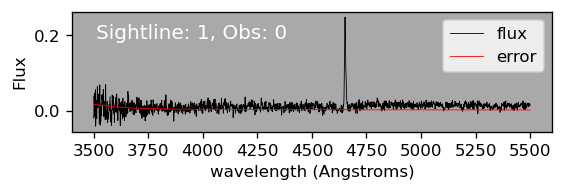

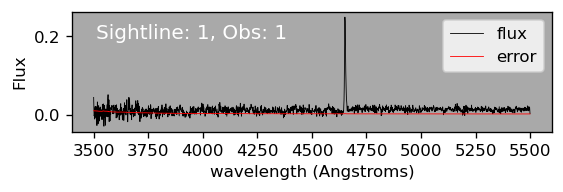

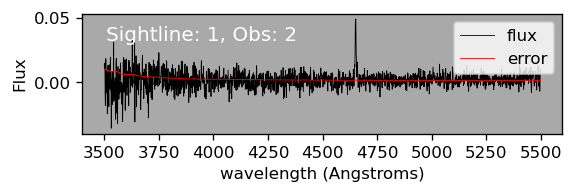

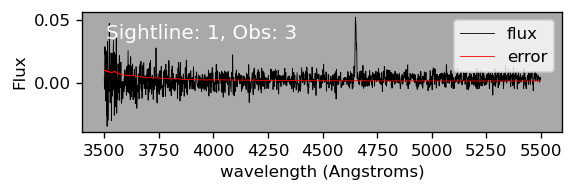

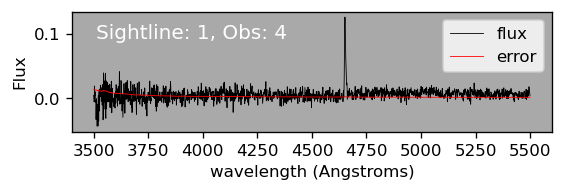

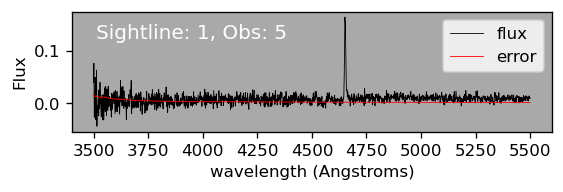

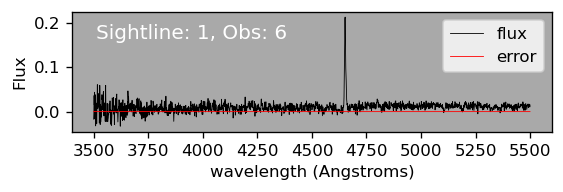

# of spectra=7
fluxlen=2000


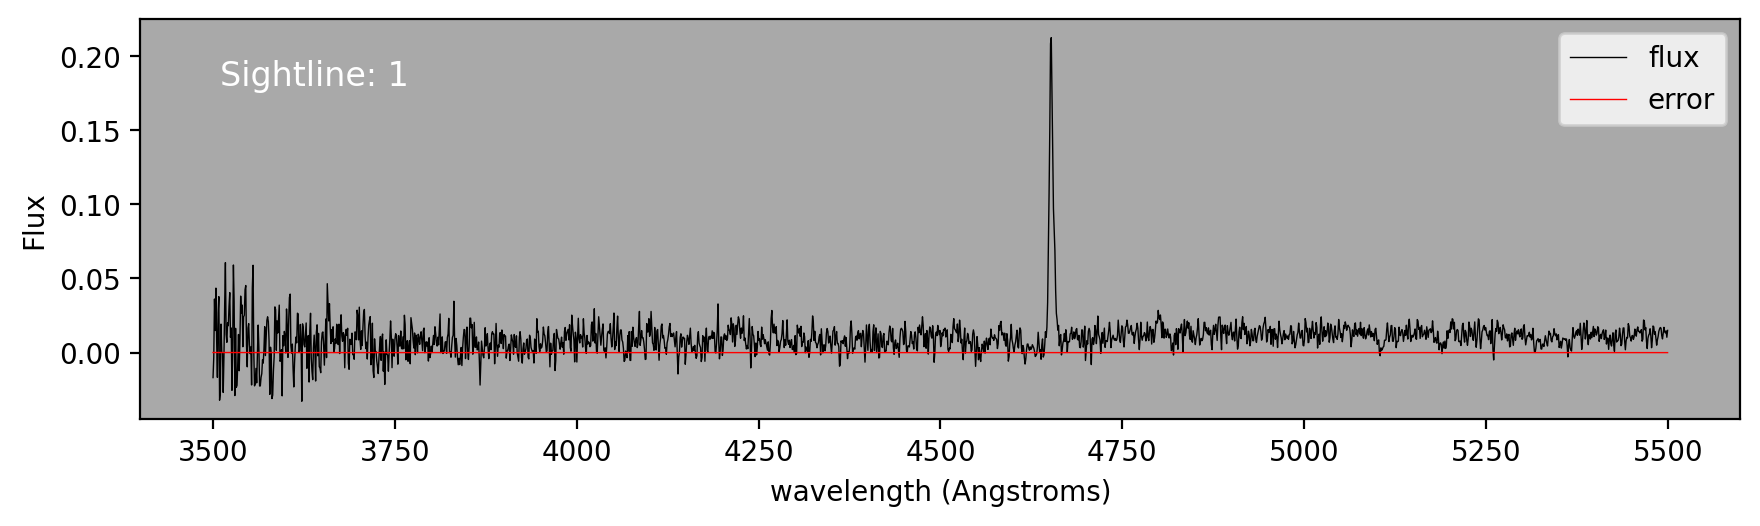

writing combined spectrum to /Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_231119/1_1d_combined_spectra_27.36-3x9/1_1d_combined_spectra_27.36-3x9.fits
Wrote spectrum to /Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_231119/1_1d_combined_spectra_27.36-3x9/1_1d_combined_spectra_27.36-3x9.fits

Sightline 2: x=30, y=37, w=3, h=11, radecs=(array([217.47897812, 217.47872977]), array([12.04354425, 12.04443481])) 
=============== BEGINNING EXTRACTION FOR RA:217.47897811679388 DEC:12.043544250362512 ==================


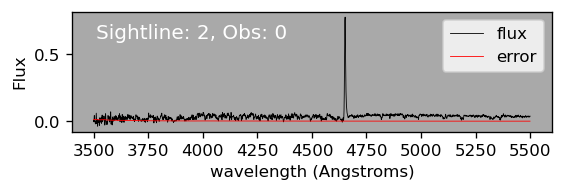

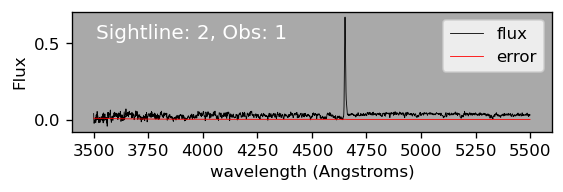

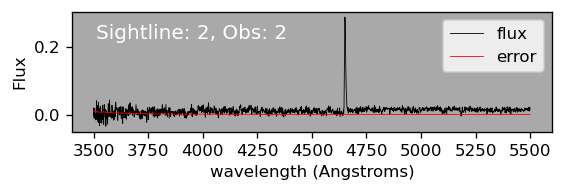

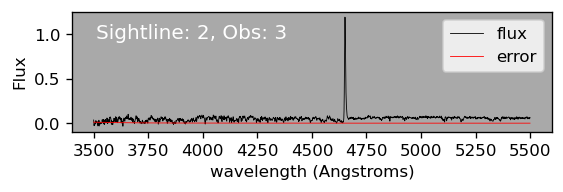

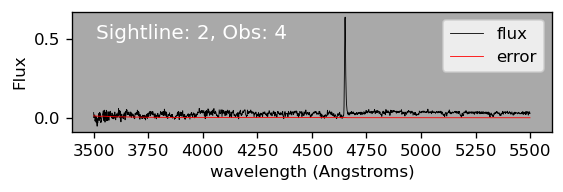

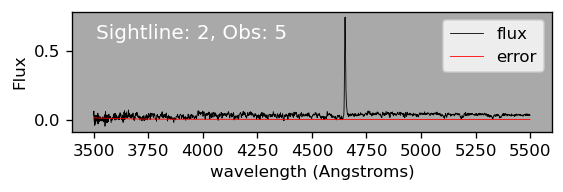

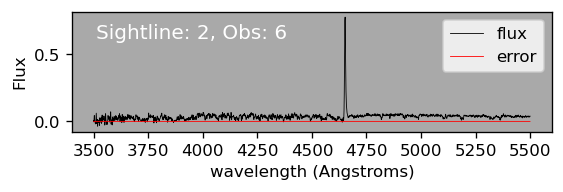

# of spectra=7
fluxlen=2000


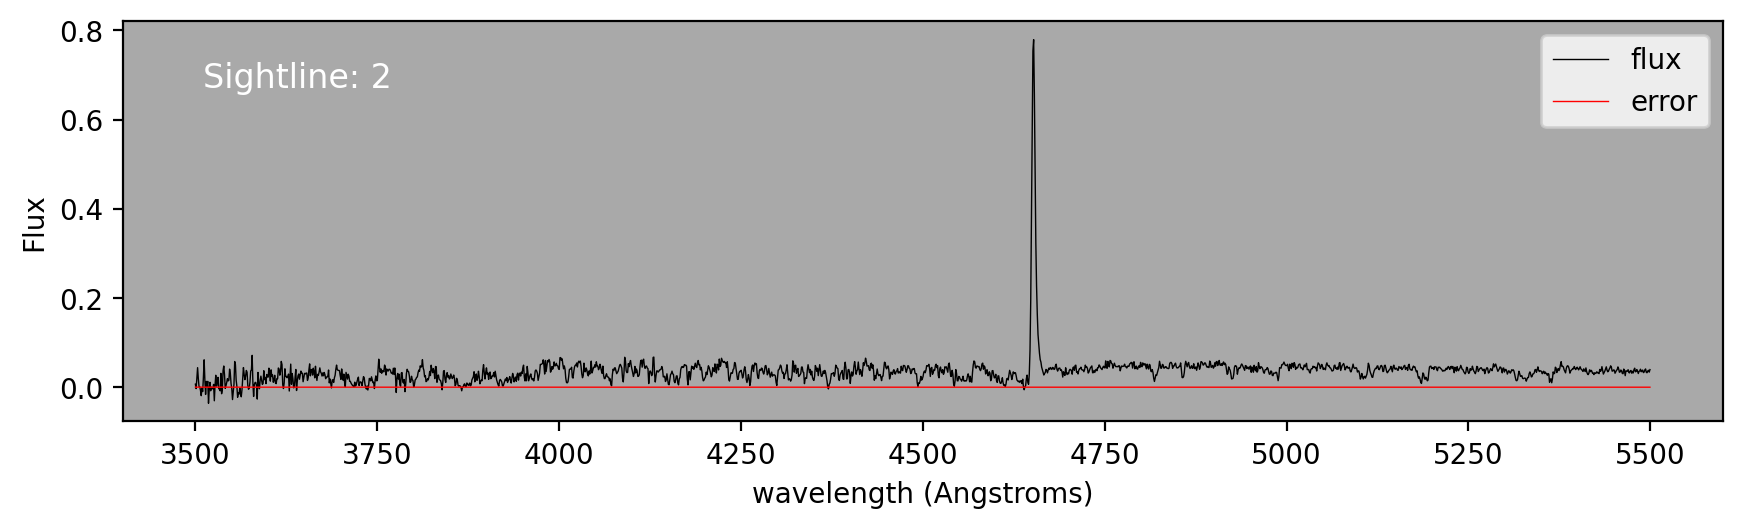

writing combined spectrum to /Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_231119/2_1d_combined_spectra_30.37-3x11/2_1d_combined_spectra_30.37-3x11.fits
Wrote spectrum to /Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_231119/2_1d_combined_spectra_30.37-3x11/2_1d_combined_spectra_30.37-3x11.fits

Sightline 3: x=33, y=38, w=3, h=11, radecs=(array([217.47872977, 217.47848142]), array([12.04362521, 12.04451577])) 
=============== BEGINNING EXTRACTION FOR RA:217.47872977050793 DEC:12.043625210435723 ==================


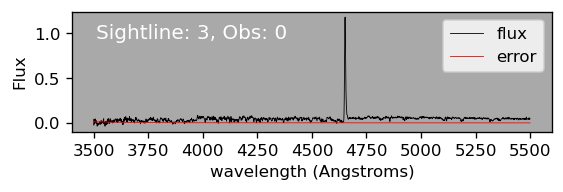

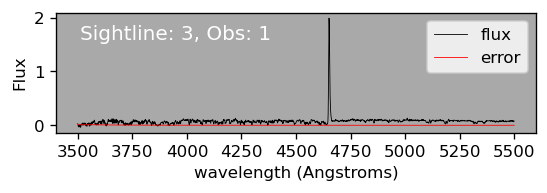

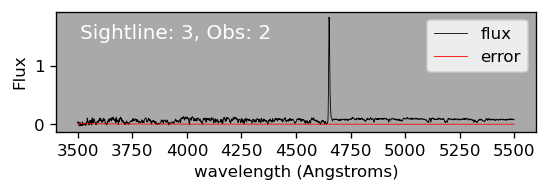

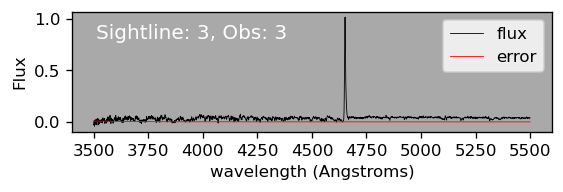

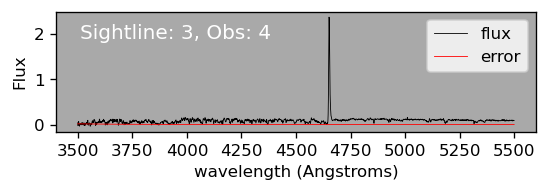

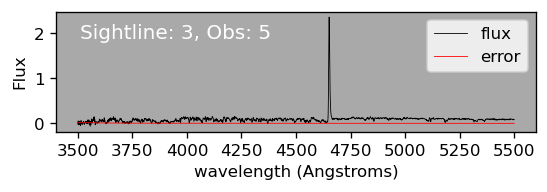

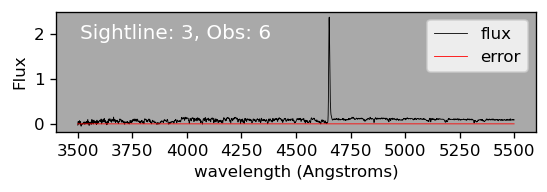

# of spectra=7
fluxlen=2000


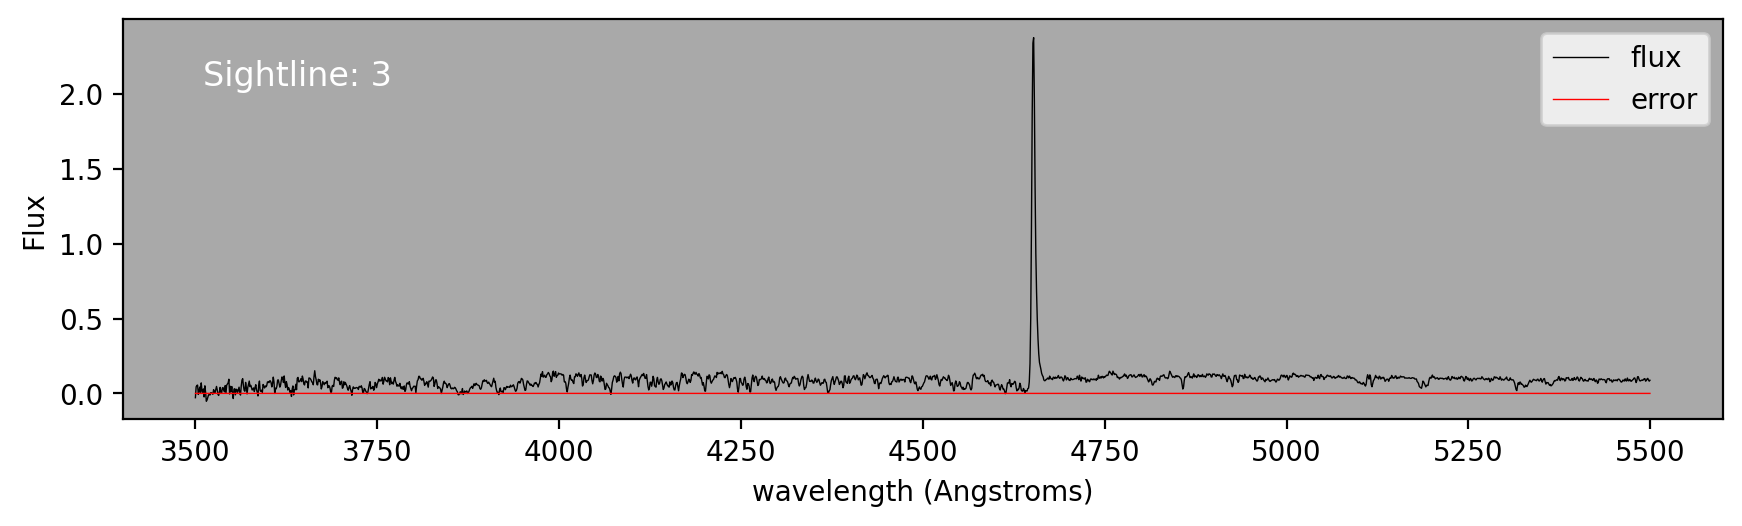

writing combined spectrum to /Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_231119/3_1d_combined_spectra_33.38-3x11/3_1d_combined_spectra_33.38-3x11.fits
Wrote spectrum to /Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_231119/3_1d_combined_spectra_33.38-3x11/3_1d_combined_spectra_33.38-3x11.fits

Sightline 4: x=36, y=39, w=3, h=11, radecs=(array([217.47848142, 217.47823308]), array([12.04370617, 12.04459673])) 
=============== BEGINNING EXTRACTION FOR RA:217.4784814240722 DEC:12.04370617028928 ==================


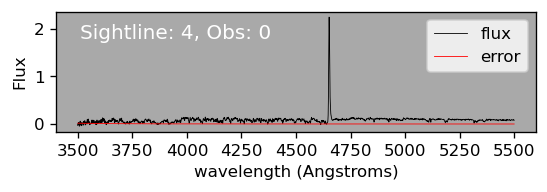

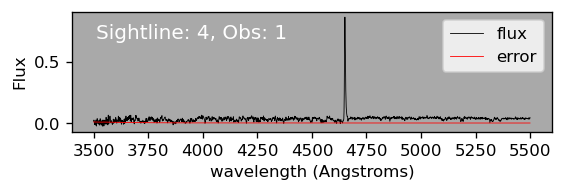

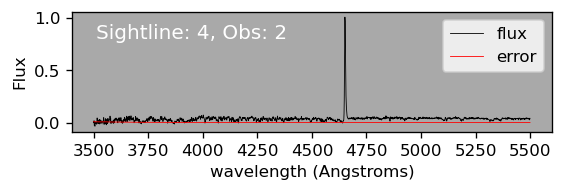

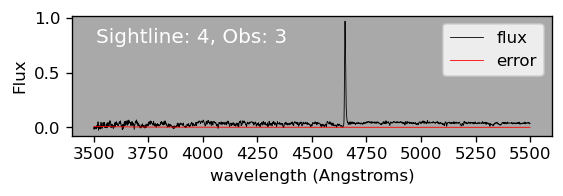

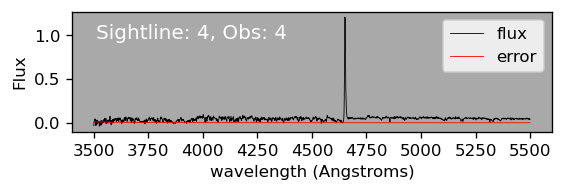

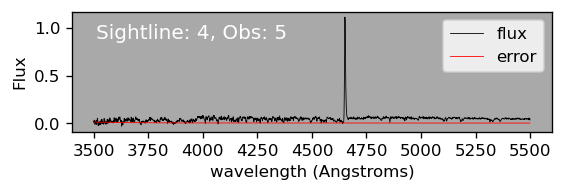

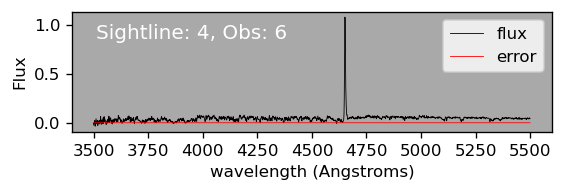

# of spectra=7
fluxlen=2000


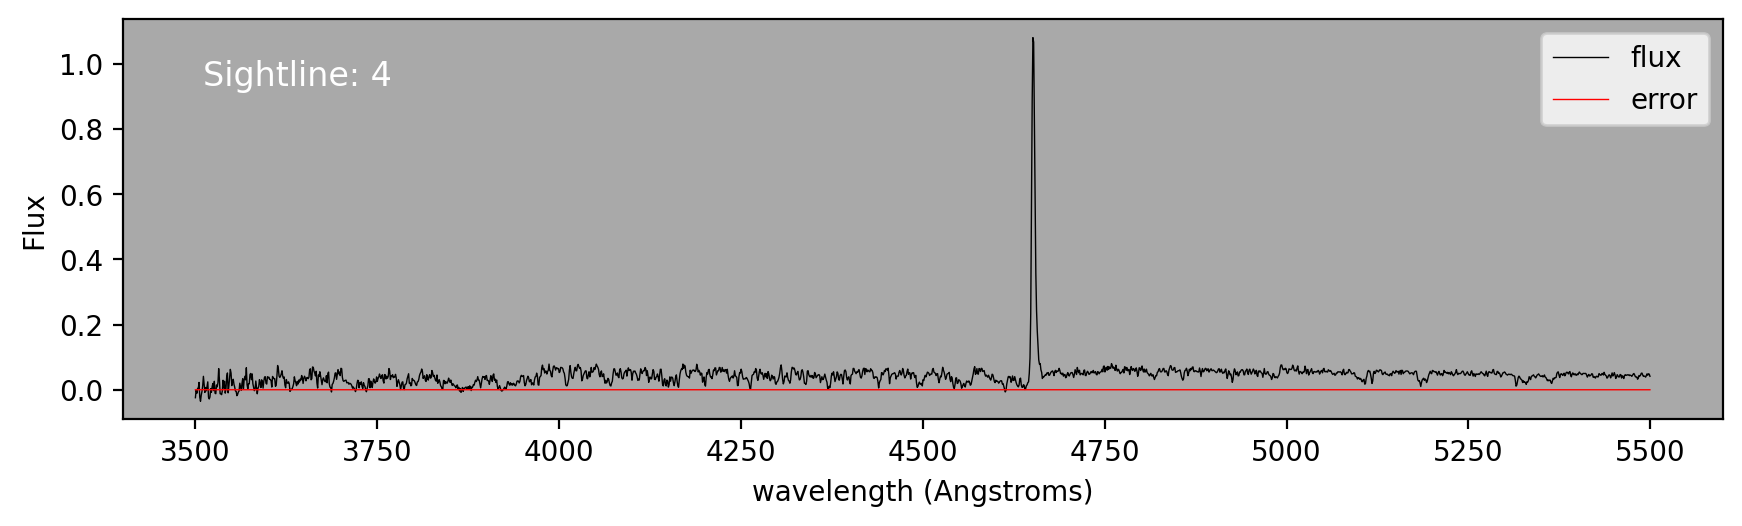

writing combined spectrum to /Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_231119/4_1d_combined_spectra_36.39-3x11/4_1d_combined_spectra_36.39-3x11.fits
Wrote spectrum to /Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_231119/4_1d_combined_spectra_36.39-3x11/4_1d_combined_spectra_36.39-3x11.fits

Sightline 5: x=40, y=39, w=5, h=7, radecs=(array([217.47823308, 217.47781916]), array([12.04386809, 12.04443481])) 
=============== BEGINNING EXTRACTION FOR RA:217.47823307732455 DEC:12.043868089923162 ==================


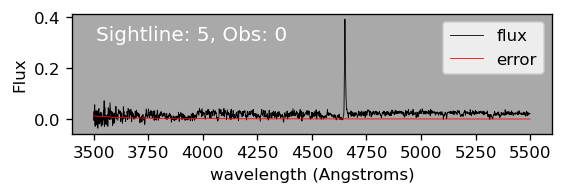

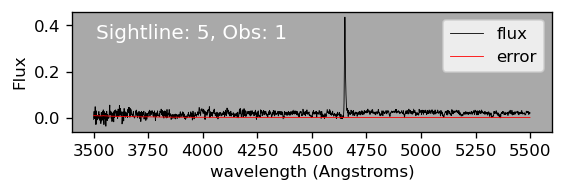

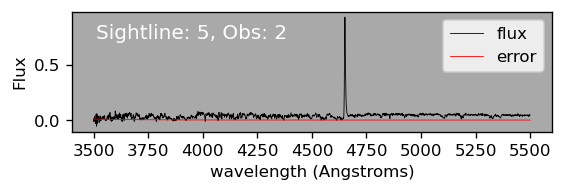

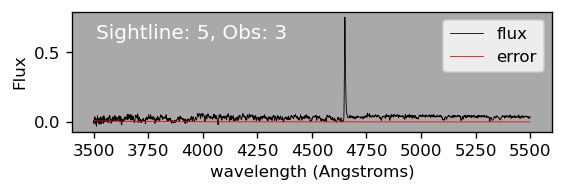

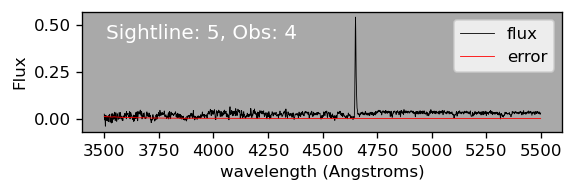

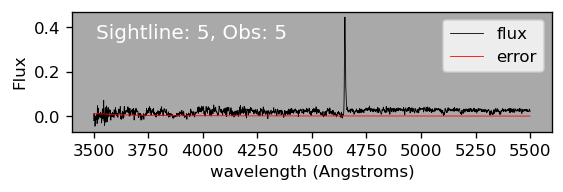

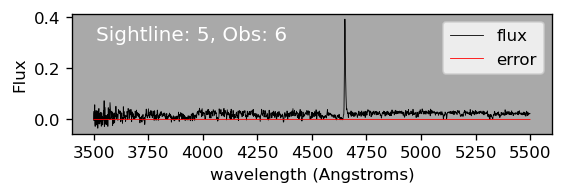

# of spectra=7
fluxlen=2000


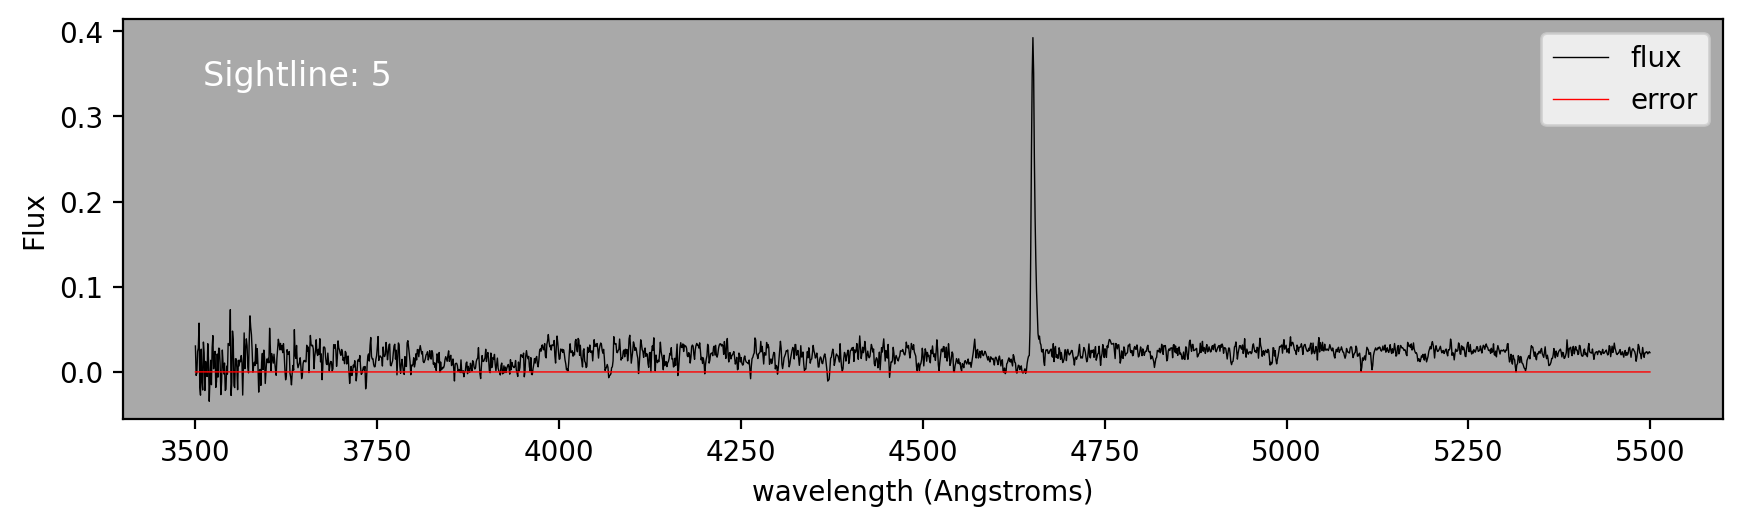

writing combined spectrum to /Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_231119/5_1d_combined_spectra_40.39-5x7/5_1d_combined_spectra_40.39-5x7.fits
Wrote spectrum to /Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_231119/5_1d_combined_spectra_40.39-5x7/5_1d_combined_spectra_40.39-5x7.fits

Sightline 6: x=49, y=31, w=11, h=7, radecs=(array([217.47773639, 217.47682578]), array([12.04322041, 12.04378712])) 
=============== BEGINNING EXTRACTION FOR RA:217.47773638667437 DEC:12.043220408532045 ==================


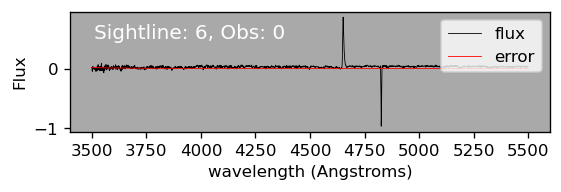

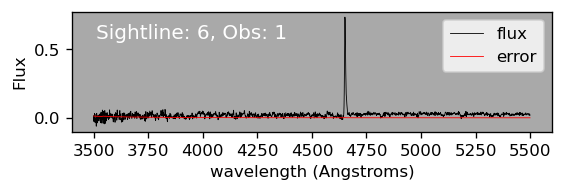

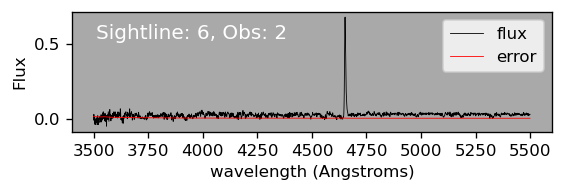

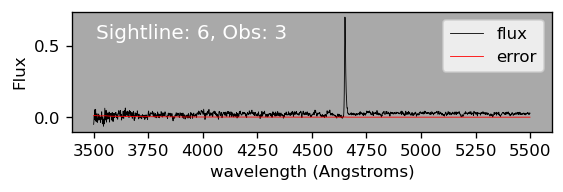

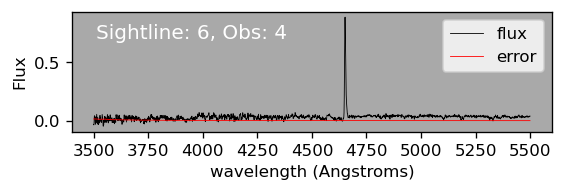

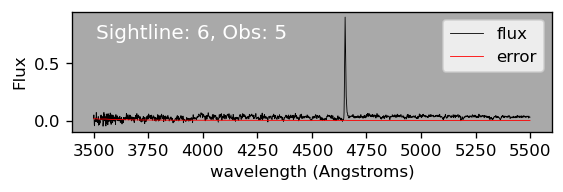

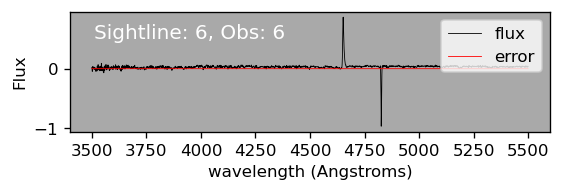

# of spectra=7
fluxlen=2000


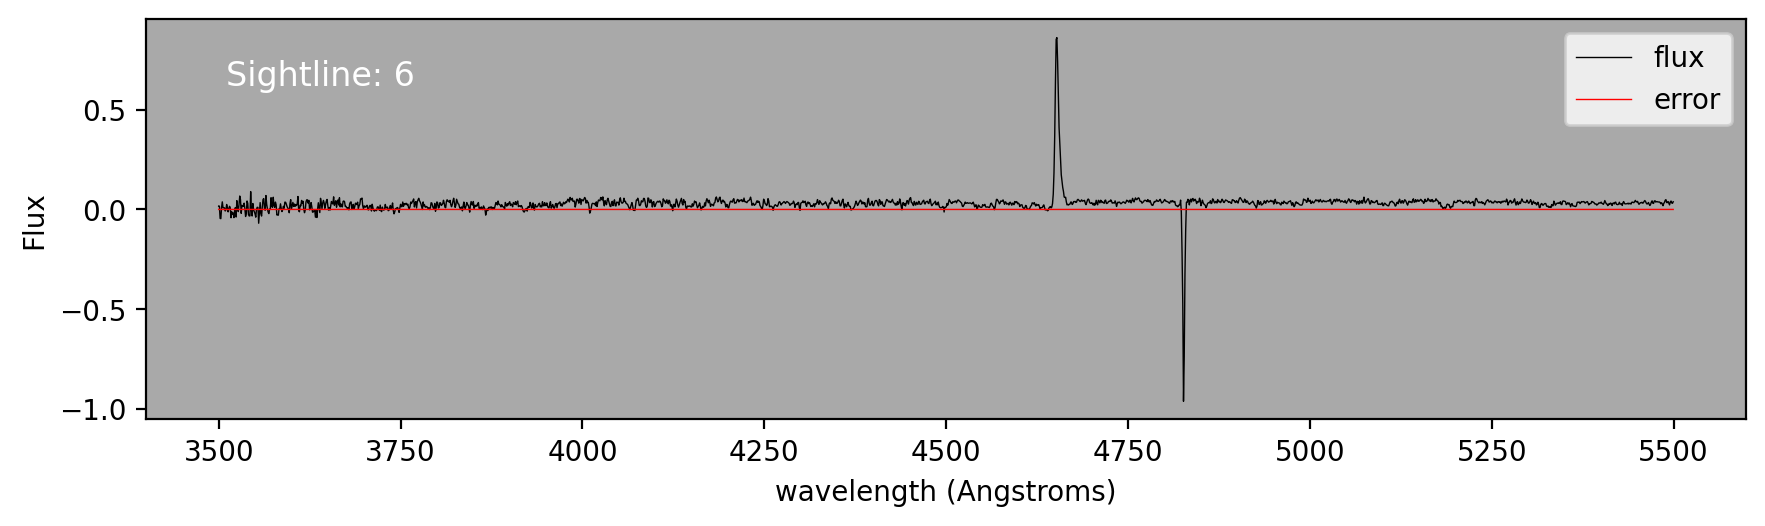

writing combined spectrum to /Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_231119/6_1d_combined_spectra_49.31-11x7/6_1d_combined_spectra_49.31-11x7.fits
Wrote spectrum to /Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_231119/6_1d_combined_spectra_49.31-11x7/6_1d_combined_spectra_49.31-11x7.fits

Sightline 7: x=34, y=23, w=11, h=7, radecs=(array([217.47897812, 217.47806751]), array([12.04257273, 12.04313945])) 
=============== BEGINNING EXTRACTION FOR RA:217.4789781160452 DEC:12.042572730362634 ==================


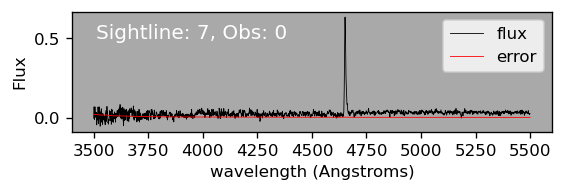

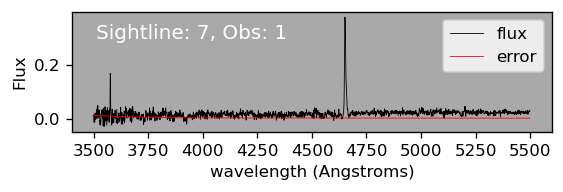

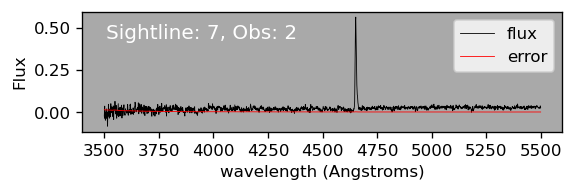

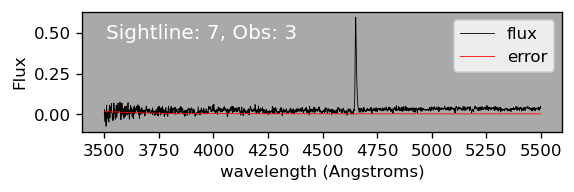

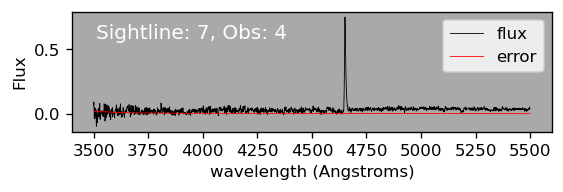

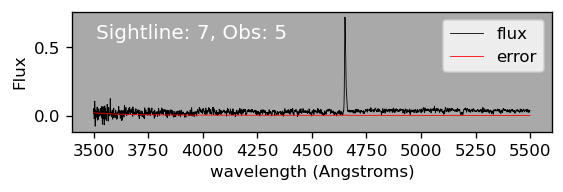

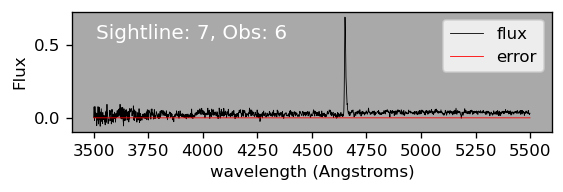

# of spectra=7
fluxlen=2000


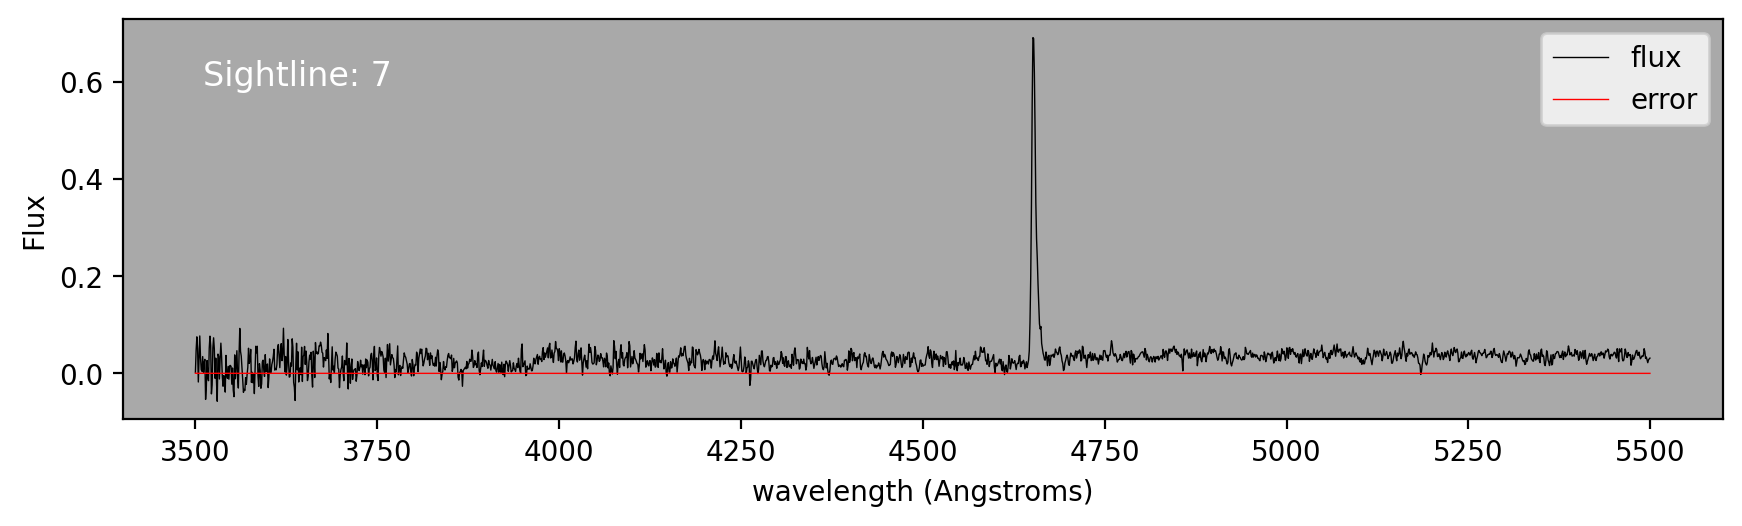

writing combined spectrum to /Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_231119/7_1d_combined_spectra_34.23-11x7/7_1d_combined_spectra_34.23-11x7.fits
Wrote spectrum to /Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_231119/7_1d_combined_spectra_34.23-11x7/7_1d_combined_spectra_34.23-11x7.fits


In [10]:
output_dir = "/Users/robertseaton/School/github_repos/CGM-learning/code/analysis/J1429+1202_231119"
for sl in sightlines:
    print(f"""
{sl}""")
    sl_radec = sl.radecs
    specs = bo.extract_spectra_from_obs(sl_radec, obs)
    for i, spec in enumerate(specs):
 
        plot_spectra(sl, spec, label=f"Sightline: {sl.label}, Obs: {i}", figsize=(4,1), dpi=120)
        # print(f"sp.flux:{np.shape(sp.flux)}, sp.sig:{np.shape(sp.sig)}, sp.wavelength:{np.shape(sp.wavelength)}")
        
    combined_xspec1d = bu.combine_spectra_ivw2(specs)            
    plot_spectra(sl, combined_xspec1d, label=f"Sightline: {sl.label}")
    base_name = f"{sl.label}_1d_combined_spectra_{sl.x}.{sl.y}-{sl.w}x{sl.h}"
    target_dir = os.path.join(output_dir, base_name)
    if not os.path.exists(target_dir): os.makedirs(target_dir)
    full_pathname = os.path.join(target_dir, base_name + ".fits")
    print(f"writing combined spectrum to {full_pathname}")
    combined_xspec1d.write_to_fits(full_pathname, clobber=True)

